In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)

DATA_STORE = Path('..', 'data', 'assets.h5')

In [2]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [3]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

In [8]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500') #shape[0]=69
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()      #shape[0]=69 - rolling_window + 1
return_params[['sp500']] = annual_returns[['sp500']]
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))
return_params.sp500.describe()

count    45.000000
mean      0.101771
std       0.158334
min      -0.384858
25%       0.010620
50%       0.124008
75%       0.234542
max       0.341107
Name: sp500, dtype: float64

In [5]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), mean - 3 * std, mean + 3 * std)
    return -val

def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

def get_kelly_share(data):
    #这里bound上限为2;从sp500年收益min=-0.384858，最高只能是2倍杠杆，再高就爆仓了
    solution = minimize_scalar(norm_integral, args=(data['mean'], data['std']), bounds=[0, 2], method='bounded') 
    return pd.Series([solution.x, -1*solution.fun], index=['opt_share','exp_max_return'])

return_params[['opt_share','exp_max_return']] = return_params.apply(get_kelly_share, axis=1)
return_params[['opt_share_shift']] = return_params[['opt_share']].shift()
#return_params.sp500类型是series，mul结果也是series；所以用['key_return']而不是[['key_return']]
return_params['kelly_return'] = return_params.sp500.mul(return_params.opt_share_shift)
return_params = return_params[['sp500', 'kelly_return', 'exp_max_return', 'opt_share', 'opt_share_shift', 'mean', 'std']]

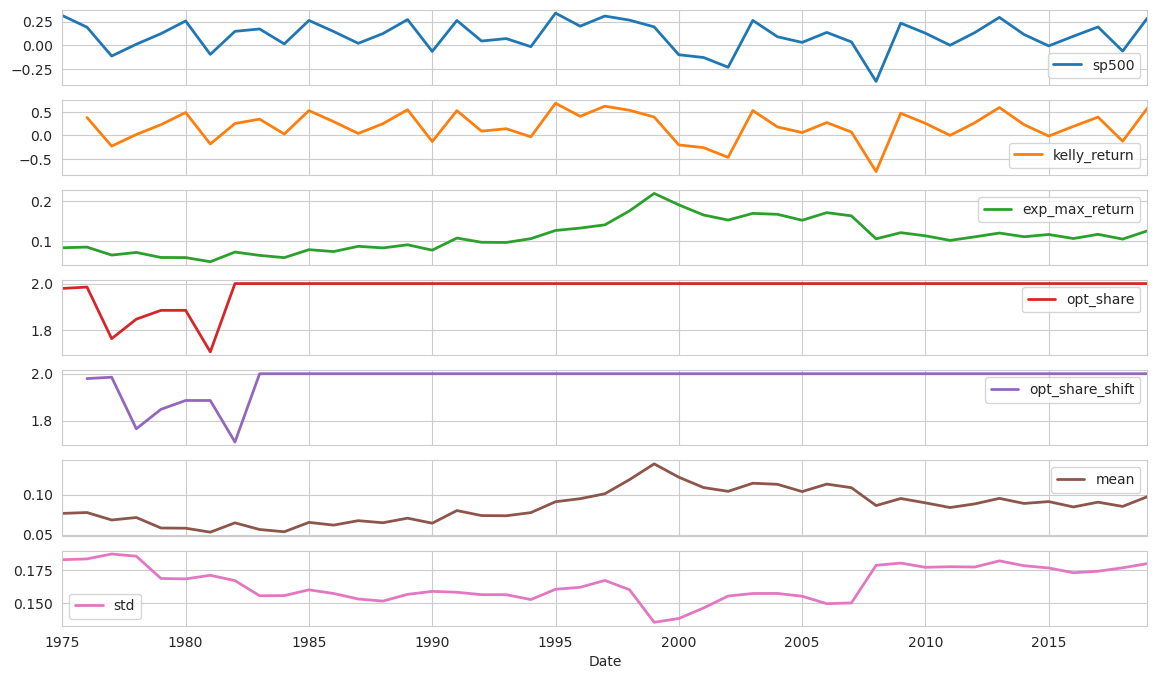

In [6]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

<Axes: xlabel='Date'>

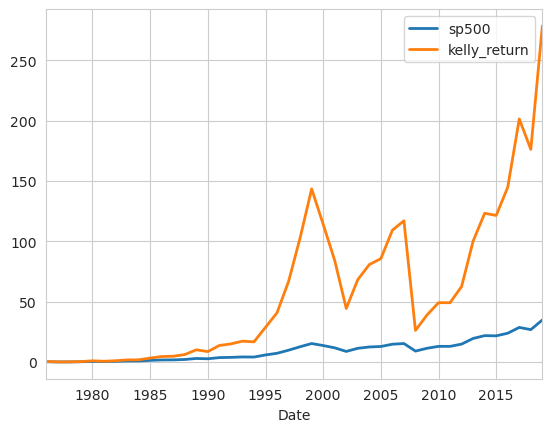

In [7]:
return_params[['sp500', 'kelly_return']].dropna().add(1).cumprod().sub(1).plot(lw=2)

In [9]:
m = .058
s = .216

# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')

# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))

print(f'Optimal Kelly fraction1:{sol.x:.4f} fraction2:{x0:.4f}')

Optimal Kelly fraction1:1.1974 fraction2:1.1974


In [10]:
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns

cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

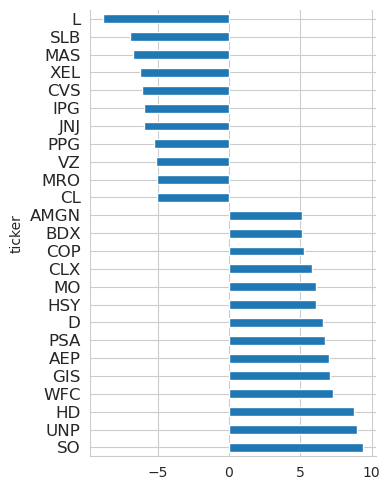

In [16]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(4, 5))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

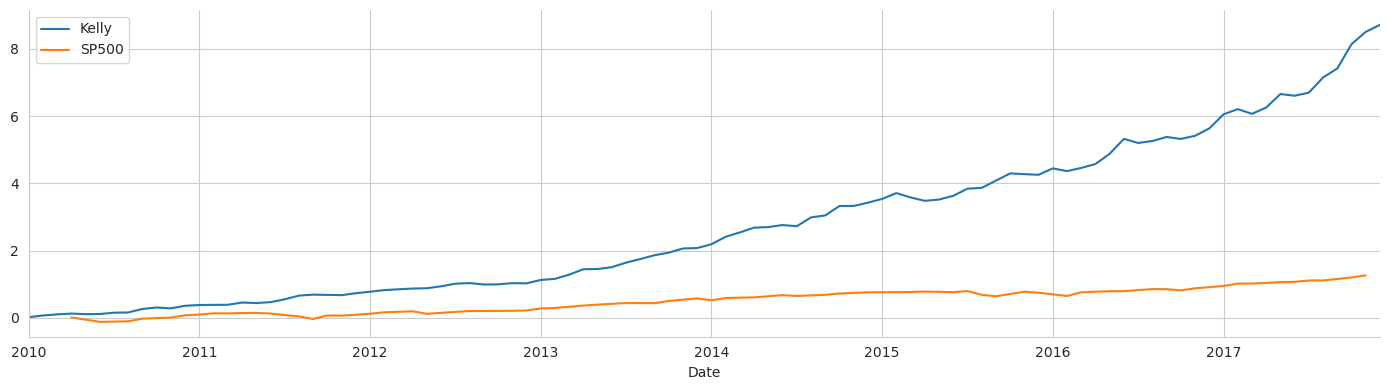

In [12]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();